# CONTINUAL LEARNING using Gated Linear Networks

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
%cd drive/MyDrive/'Colab Notebooks/MetaLearning'
!ls

[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/MetaLearning'
/content/drive/MyDrive/Colab Notebooks/MetaLearning
HW2.ipynb	models.ipynb  nb2-CNP.ipynb  nb4-exp.ipynb  pygln
l2lutils.ipynb	nb1.ipynb     nb3.ipynb      nb4.ipynb	    utils.ipynb


In [69]:
!pip install import_ipynb --quiet
!pip install learn2learn --quiet

In [70]:
import import_ipynb
import utils
import models
utils.hide_toggle('Imports 1')

In [71]:
from IPython import display
import torch
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
# from l2lutils import KShotLoader
from IPython import display
utils.hide_toggle('Imports 2')

l2lutils

In [72]:
import torch
import numpy as np
import learn2learn as l2l
from learn2learn.data import *
import import_ipynb
import utils
class KShotLoader():
    def __init__(self,myds,num_tasks=1000,shots=2,ways=2,classes=None):
        self.shots = shots
        self.ways = ways
        self.myMds = l2l.data.MetaDataset(myds)
        if classes == None:
            n_classes = len(set(myds.labels))
            classes = [i for i in range(n_classes)]
        self.my_tasks = l2l.data.TaskDataset(self.myMds, task_transforms=[
                                l2l.data.transforms.FilterLabels(self.myMds,classes),
                                l2l.data.transforms.NWays(self.myMds,ways),
                                l2l.data.transforms.KShots(self.myMds,2*shots),
                                l2l.data.transforms.LoadData(self.myMds),
                                l2l.data.transforms.RemapLabels(self.myMds),
                                l2l.data.transforms.ConsecutiveLabels(self.myMds)
                                ],num_tasks=num_tasks)
    def get_task(self):
        data,labels = self.my_tasks.sample()
        adaptation_indices = np.zeros(data.size(0), dtype=bool)
        adaptation_indices[np.arange(self.shots*self.ways) * 2] = True
        evaluation_indices = torch.from_numpy(~adaptation_indices)
        adaptation_indices = torch.from_numpy(adaptation_indices)
        adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
        evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]
        d_train = (adaptation_data,adaptation_labels)
        d_test = (evaluation_data,evaluation_labels)
        return d_train, d_test

# Data Generation and Loading

In [73]:
#Generate data - euclidean
meta_train_ds, meta_test_ds, full_loader = utils.euclideanDataset(n_samples=20000,n_features=20,n_classes=10,batch_size=32)

In [74]:
# Define an MLP network. Note that input dimension has to be data dimension. For classification
# final dimension has to be number of classes; for regression one.
#torch.manual_seed(10)
net = models.MLP(dims=[20,32,32,10])

In [75]:
# Train the network; note that network is trained in place so repeated calls further train it.
net,losses,accs=models.Train(net,full_loader,lr=1e-2,epochs=10,verbose=True)

Epoch   9 Loss: 1.20632e-01 Accuracy: 0.98008


In [76]:
#Training accuracy.
models.accuracy(net,meta_train_ds.samples,meta_train_ds.labels,verbose=True)

14733.0 15000


0.9822

In [77]:
# Test accuracy.
models.accuracy(net,meta_test_ds.samples,meta_test_ds.labels)

4889.0 5000


0.9778

# Meta-Learning: Tasks

Generate a k-shot n-way loader using the meta-training dataset

In [78]:
meta_train_kloader=KShotLoader(meta_train_ds,shots=5,ways=5)

Sample a task - each task has a k-shot n-way training set and a similar test set

In [79]:
d_train,d_test=meta_train_kloader.get_task()

Let's try directly learning using the task training set albeit its small size: create a dataset and loader and train it with the earlier network and Train function.

In [80]:
taskds = utils.MyDS(d_train[0],d_train[1])

In [81]:
d_train_loader = torch.utils.data.DataLoader(dataset=taskds,batch_size=1,shuffle=True)

In [82]:
net,loss=models.Train(net,d_train_loader,lr=1e-1,epochs=10,verbose=False)

ValueError: ignored

How does it do on the test set of the sampled task?

In [ ]:
models.accuracy(net,d_test[0],d_test[1])

# Gated Linear Networks

In [83]:
from pygln import GLN

## GLN Interface

### Constructor

```python
GLN(backend: str,
    layer_sizes: Sequence[int],
    input_size: int,
    context_map_size: int = 4,
    num_classes: int = 2,
    base_predictor: Optional[Callable] = None,
    learning_rate: float = 1e-4,
    pred_clipping: float = 1e-3,
    weight_clipping: float = 5.0,
    bias: bool = True,
    context_bias: bool = True)
```

Gated Linear Network constructor.

**Args:**

- **backend** (*"jax", "numpy", "pytorch", "tf"*): Which backend implementation to use.
- **layer\_sizes** (*list[int >= 1]*): List of layer output sizes.
- **input\_size** (*int >= 1*): Input vector size.
- **num\_classes** (*int >= 2*): For values >2, turns GLN into a multi-class classifier by
    internally creating a one-vs-all binary GLN classifier per class and return the argmax as
    output.
- **context\_map\_size** (*int >= 1*): Context dimension, i.e. number of context halfspaces.
- **bias** (*bool*): Whether to add a bias prediction in each layer.
- **context\_bias** (*bool*): Whether to use a random non-zero bias for context halfspace gating.
- **base\_predictor** (*np.array[N] -> np.array[M]*): If given, maps the N-dim input vector to a
    corresponding M-dim vector of base predictions (could be a constant prior), instead of
    simply using the clipped input vector itself.
- **learning\_rate** (*float > 0.0*): Update learning rate.
- **pred\_clipping** (*0.0 < float < 0.5*): Clip predictions into [p, 1 - p] at each layer.
- **weight\_clipping** (*float > 0.0*): Clip weights into [-w, w] after each update.

---

### Predict

```python
GLN.predict(input: np.ndarray,
            target: np.ndarray = None,
            return_probs: bool = False) -> np.ndarray
```

Predict the class for the given inputs, and optionally update the weights.

> **PyTorch** implementation takes `torch.Tensor`s (on the same device as the model) as parameters.

**Args:**

- **input** (*np.array[B, N]*): Batch of B N-dim float input vectors.
- **target** (*np.array[B]*): Optional batch of B bool/int target class labels which, if given,
    triggers an online update if given.
- **return\_probs** (*bool*): Whether to return the classification probability (for each
    one-vs-all classifier if num_classes given) instead of the class.

**Returns:**

- Predicted class per input instance, or classification probabilities if return_probs set.

---

Sampling a training task: Note that each of d_train and d_test is a tuple comprising of a training set, and labels.

In [94]:
meta_train_kloader=KShotLoader(meta_train_ds,shots=100,ways=2)

In [95]:
meta_test_kloader=KShotLoader(meta_test_ds,shots=100,ways=2)

In [96]:
d_train,d_test=meta_train_kloader.get_task()
rp = torch.randperm(d_train[1].shape[0])
d_train0=d_train[0][rp]
d_train1=d_train[1][rp]

In [97]:
f=(lambda x: (x - x.min(axis=1, keepdims=True)[0]) /(x.max(axis=1, keepdims=True)[0] - x.min(axis=1, keepdims=True)[0])+0.01)

In [98]:
f=(lambda x: x/2*x)

In [99]:
gln = GLN(backend='pytorch', layer_sizes=[4, 4, 1], input_size=20,base_predictor=f)
lossfn = torch.nn.NLLLoss()

In [100]:
for i in range(100):
    preds = gln.predict(d_train0[i:i+50],d_train1[i:i+50],return_probs=True)
    #print(preds)
    #print(d_train[1][i:1+10].unsqueeze(0))
    pt = torch.tensor(preds).unsqueeze(-1)
    ph = torch.cat((torch.log(1-pt),torch.log(pt)),dim=1)
    loss = lossfn(ph,d_train1[i:i+50])
    #print(ph[0:10])
    #print(d_train1[i:i+10])
    print(loss)
    display.clear_output(wait=True)

tensor(0.1398)


In [101]:
d_train,d_test=meta_test_kloader.get_task()

In [102]:
preds = gln.predict(d_train[0],d_train[1],return_probs=True)
pt = torch.tensor(preds).unsqueeze(-1)
ph = torch.cat((pt,1-pt),dim=1)
lossfn(ph,d_train[1])
d_train[1]

/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float32)
/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  base_preds = torch.tensor(base_preds, dtype=torch.float32)
/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

In [103]:
t = d_train[0][0].unsqueeze(0)
#(t.max(axis=1, keepdims=False) - t.min(axis=1, keepdims=False))
#torch.min(t,axis=1,keepdims=False)[0]
f(t)

tensor([[10.1319,  1.0500,  0.7943,  3.0434,  4.6933,  1.7292,  3.2657,  3.1643,
          0.7461,  0.0877,  1.6829,  3.4036,  6.4277,  2.5511, 18.4707,  0.7622,
          0.5033,  0.3035,  7.6870,  3.0088]])

# Putting it all together: 
# Continually Training a Gated Linear Network
Now let's put all of the above in a loop - continually training a Gated Linear Network:

In [104]:
class TaskStore():
    def __init__(self):
        self.XL = []
        self.yL = []
        self.i = 0
        self.n = 0
    def save_task(self,X,y):
        self.XL += [X]
        self.yL += [y]
        self.n += 1
    def get_task(self):
        if self.i < self.n:
            X = self.XL[self.i]
            y = self.yL[self.i]
            self.i += 1
            return X,y,False
        else:
            return self.XL[0],self.yL[0],True
    def reset(self):
        self.i = 0
        self.n = 0
    def load(self,loader,n_tasks=5):
        for t in range(n_tasks):
            d_train,d_test=loader.get_task()
            rp = torch.randperm(d_train[1].shape[0])
            d_train0=d_train[0][rp]
            d_train1=d_train[1][rp]
            rp1 = torch.randperm(d_test[1].shape[0])
            d_test0=d_test[0][rp1]
            d_test1=d_test[1][rp1]
            X = torch.cat((d_train0,d_test0),axis=0)
            y = torch.cat((d_train1,d_test1),axis=0)
            self.save_task(X,y)

In [105]:
f = (lambda x: (x - x.min(axis=1, keepdims=True)[0]) / (x.max(axis=1, keepdims=True)[0] - x.min(axis=1, keepdims=True)[0])
    )

In [106]:
def gln_acc(Net,X_test,y_test,verbose=False):
    m = X_test.shape[0]
    preds = Net.predict(X_test,return_probs=True)
    pt = torch.tensor(preds).unsqueeze(-1)
    ph = torch.cat((torch.log(1-pt),torch.log(pt)),dim=1)
    _,predicted = torch.max(ph,axis=1)
    correct = (predicted == y_test).float().sum().item()
    accuracy = correct/m
    if verbose: print(accuracy)
    return accuracy

In [119]:
import learn2learn as l2l
import numpy as np
import torch.optim as optim
shots,ways = 200,2
n_features = 20
net = GLN(learning_rate=1e-2,backend='pytorch', layer_sizes=[16, 32, 8, 1], 
          input_size=20,base_predictor=f,context_map_size=16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [120]:
#Meta-testing task loader for later.
meta_test_kloader=KShotLoader(meta_test_ds,shots=shots,ways=ways)
meta_train_kloader=KShotLoader(meta_train_ds,shots=shots,ways=ways,num_tasks=1000)

In [121]:
trainStore = TaskStore()
testStore = TaskStore()

In [122]:
trainStore.load(meta_train_kloader,n_tasks=25)
testStore.load(meta_test_kloader,n_tasks=25)

In [123]:
def runGLN(net,task_store,learn=True,task_count=5,batch_size=32,epochs=1,frac=1.0):
    lossfn = torch.nn.NLLLoss()
    bs = batch_size
    lossL=[]
    accs_trainL=[]
    accs_testL=[]
    accsL=[]
    n_batch = 0
    start = shots
    for task in range(task_count):
        task_loss = 0.0
        # load task and train/predict on it
        X,y,_ = task_store.get_task()
        i = 0
        n = int(X.shape[0]/2)
        n_train = int(n/frac)
        for e in range(epochs):
            while (i<n_train-bs):
                if learn==True: preds = net.predict(X[i:i+bs],y[i:i+bs],return_probs=True)
                else: preds = net.predict(X[i:i+bs],return_probs=True)
                pt = torch.tensor(preds).unsqueeze(-1)
                ph = torch.cat((torch.log(1-pt),torch.log(pt)),dim=1)
                loss = lossfn(ph,y[i:i+bs])
                lossL+=[loss]
                n_batch+=1
                i+=bs
        # Training accuracy
        acc_train = gln_acc(net,X[0:n],y[0:n])
        # Test accuracy
        acc_test = gln_acc(net,X[n:2*n],y[n:2*n])
        acc = (acc_train+acc_test)/2
        accsL += [acc]
        accs_trainL += [acc_train]
        accs_testL += [acc_test]
        print("Task:",task,sum(lossL)/n_batch,acc_train,acc_test)
    return lossL,accsL,accs_trainL,accs_testL

    

In [124]:
trainStore.i=0
testStore.i=0

In [125]:
lossL1,accsA1,accsTr1,accsTe1=runGLN(net,trainStore,epochs=1,task_count=25)
#gln_acc(net,X,y)

/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float32)
/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  base_preds = torch.tensor(base_preds, dtype=torch.float32)
/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


Task: 0 tensor(0.6536) 0.995 0.7075
Task: 1 tensor(0.6519) 0.9875 0.6875
Task: 2 tensor(0.6297) 0.995 0.795
Task: 3 tensor(0.6419) 0.9775 0.69
Task: 4 tensor(0.6563) 0.985 0.575
Task: 5 tensor(0.6678) 0.985 0.5725
Task: 6 tensor(0.6875) 0.9775 0.4775
Task: 7 tensor(0.6980) 0.985 0.5825
Task: 8 tensor(0.6943) 0.9875 0.6125
Task: 9 tensor(0.6769) 0.9925 0.8175
Task: 10 tensor(0.6841) 0.9825 0.57
Task: 11 tensor(0.6729) 0.9925 0.745
Task: 12 tensor(0.6625) 0.9925 0.805
Task: 13 tensor(0.6752) 0.975 0.45
Task: 14 tensor(0.6693) 0.99 0.75
Task: 15 tensor(0.6669) 0.995 0.7175
Task: 16 tensor(0.6570) 0.9975 0.86
Task: 17 tensor(0.6711) 0.9325 0.375
Task: 18 tensor(0.6644) 0.995 0.7775
Task: 19 tensor(0.6588) 0.9925 0.7875
Task: 20 tensor(0.6736) 0.945 0.3375
Task: 21 tensor(0.6865) 0.9575 0.365
Task: 22 tensor(0.6750) 0.995 0.9175
Task: 23 tensor(0.6758) 0.985 0.635
Task: 24 tensor(0.6784) 0.965 0.6


In [126]:
trainStore.i=0
lossL2,accsA2,accsTr2,accsTe2=runGLN(net,trainStore,learn=False,epochs=1,task_count=25)

Task: 0 tensor(0.3363) 0.9325 0.79
Task: 1 tensor(0.5077) 0.565 0.1725


/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float32)
/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  base_preds = torch.tensor(base_preds, dtype=torch.float32)


Task: 2 tensor(0.4612) 0.8475 0.74
Task: 3 tensor(0.4776) 0.7525 0.46
Task: 4 tensor(0.5083) 0.6175 0.29
Task: 5 tensor(0.4775) 0.9425 0.785
Task: 6 tensor(0.4651) 0.9325 0.6075
Task: 7 tensor(0.4399) 1.0 0.8725
Task: 8 tensor(0.4582) 0.64 0.3075
Task: 9 tensor(0.4492) 0.86 0.6675
Task: 10 tensor(0.4516) 0.825 0.5775
Task: 11 tensor(0.4415) 0.93 0.7
Task: 12 tensor(0.4392) 0.895 0.58
Task: 13 tensor(0.4571) 0.5475 0.2375
Task: 14 tensor(0.4537) 0.89 0.605
Task: 15 tensor(0.4473) 0.94 0.76
Task: 16 tensor(0.4367) 0.9975 0.8475
Task: 17 tensor(0.4375) 0.92 0.465
Task: 18 tensor(0.4396) 0.77 0.585
Task: 19 tensor(0.4471) 0.7 0.36
Task: 20 tensor(0.4506) 0.8575 0.3025
Task: 21 tensor(0.4491) 0.97 0.535
Task: 22 tensor(0.4389) 0.995 0.9175
Task: 23 tensor(0.4351) 0.985 0.6925
Task: 24 tensor(0.4335) 0.965 0.6


In [127]:
t1.append(accsA1)
t2.append(accsTr2)

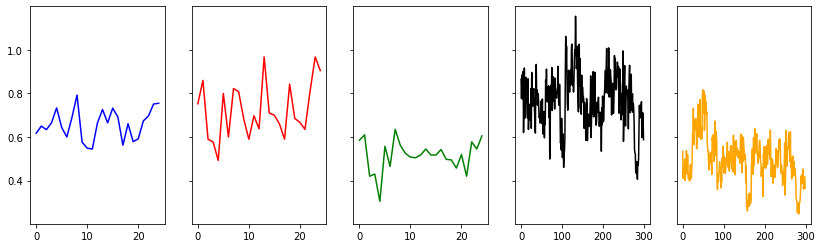

In [50]:
_,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,sharey=True,figsize=(14,4))
ax1.plot(accsA1,color='blue') # - train on 25 tasks (avg acc of train and test during training)
ax2.plot(accsTr2,color='red')  # - test on data same 25 tasks
ax3.plot(accsTe2,color='green') # - test on test data of same 25 tasks
ax4.plot(lossL1,color='black') # - losses during first training
ax5.plot(lossL2,color='orange') # - losses post training on all tasks without more training 

In [128]:
t3.append(np.sum(accsTe1)/25)

In [51]:
print("Average accuracy while training on all tasks:",np.sum(accsTe1)/25)

Average accuracy while training on all tasks: 0.5402


In [129]:
t4.append(np.sum(accsTr2)/25)

In [52]:
print("Average accuracy after training on all tasks:",np.sum(accsTr2)/25)

Average accuracy after training on all tasks: 0.722


In [53]:
t1,t2,t3,t4=[],[],[],[]

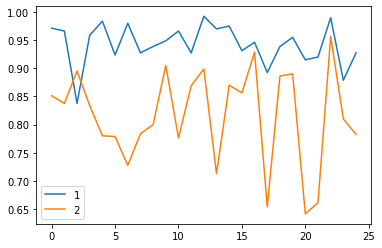

In [131]:
for j in range(1,3):
  plt.plot(t1[j],label=j)
plt.legend()

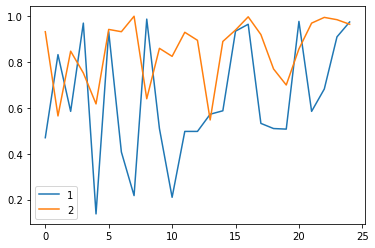

In [132]:
for j in range(1,3):
  plt.plot(t2[j],label=j)
plt.legend()

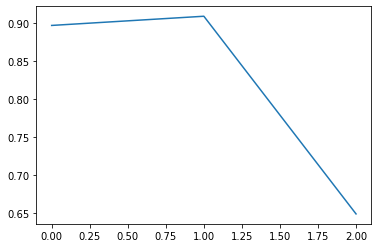

In [133]:
plt.plot(t3)

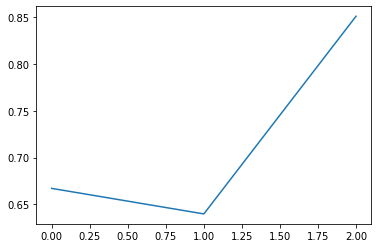

In [134]:
plt.plot(t4)

In [38]:
trainStore.i=0
lossL3,accsA3,accsTr3,accsTe3=runGLN(net,trainStore,epochs=1,task_count=25,frac=1,batch_size=10)

/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float32)
/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  base_preds = torch.tensor(base_preds, dtype=torch.float32)
/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


Task: 0 tensor(0.8606) 0.945 0.7275
Task: 1 tensor(0.6113) 0.98 0.935
Task: 2 tensor(0.5228) 0.9975 0.9425
Task: 3 tensor(0.5545) 0.985 0.895
Task: 4 tensor(0.5542) 0.99 0.9625
Task: 5 tensor(0.5329) 0.9875 0.945
Task: 6 tensor(0.5239) 0.99 0.95
Task: 7 tensor(0.5160) 0.9825 0.93
Task: 8 tensor(0.5225) 0.9925 0.8675
Task: 9 tensor(0.4803) 0.9975 0.995
Task: 10 tensor(0.4629) 0.9925 0.9625
Task: 11 tensor(0.4458) 0.9925 0.975
Task: 12 tensor(0.4228) 0.9975 0.9825
Task: 13 tensor(0.4461) 0.9975 0.93
Task: 14 tensor(0.4493) 0.99 0.94
Task: 15 tensor(0.4469) 0.99 0.9425
Task: 16 tensor(0.4370) 0.995 0.9325
Task: 17 tensor(0.4289) 0.995 0.9625
Task: 18 tensor(0.4361) 0.9925 0.905
Task: 19 tensor(0.4416) 0.995 0.9325
Task: 20 tensor(0.4330) 1.0 0.9625
Task: 21 tensor(0.4344) 0.9975 0.8925
Task: 22 tensor(0.4412) 0.985 0.8725
Task: 23 tensor(0.4431) 0.9925 0.925
Task: 24 tensor(0.4288) 0.9975 0.97


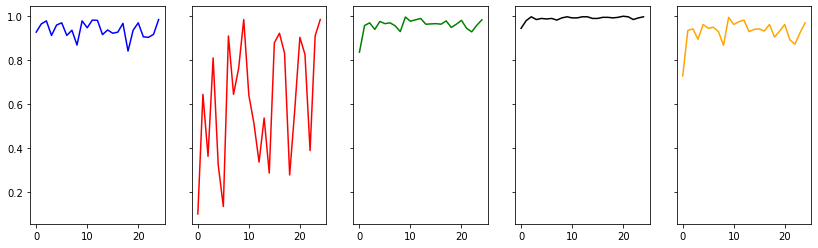

In [39]:
_,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,sharey=True,figsize=(14,4))
ax1.plot(accsA1,color='blue') # - train on 25 tasks
ax2.plot(accsA2,color='red')  # - test again on same 25 tasks
ax3.plot(accsA3,color='green') # - train again with 1/10 data 
ax4.plot(accsTr3,color='black') # - training accuracies
ax5.plot(accsTe3,color='orange') # - test accuracies

In [40]:
trainStore.i=0
testStore.i=0
lossL4,accsA4,accsTr4,accsTe4=runGLN(net,testStore,epochs=1,task_count=25,batch_size=32)

/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:263: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=torch.float32)
/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  base_preds = torch.tensor(base_preds, dtype=torch.float32)
/content/drive/My Drive/Colab Notebooks/MetaLearning/pygln/pytorch/gln.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


Task: 0 tensor(1.0643) 0.9525 0.8425
Task: 1 tensor(0.8385) 0.97 0.93
Task: 2 tensor(0.8011) 0.95 0.86
Task: 3 tensor(0.7668) 0.9425 0.815
Task: 4 tensor(0.7344) 0.9625 0.915
Task: 5 tensor(0.6461) 0.99 0.99
Task: 6 tensor(0.6833) 0.93 0.8425
Task: 7 tensor(0.7060) 0.9275 0.8175
Task: 8 tensor(0.7042) 0.9275 0.82
Task: 9 tensor(0.6978) 0.9575 0.905
Task: 10 tensor(0.6854) 0.9575 0.9375
Task: 11 tensor(0.6443) 0.9925 0.9875
Task: 12 tensor(0.6067) 0.9975 0.995
Task: 13 tensor(0.5838) 0.995 0.985
Task: 14 tensor(0.5873) 0.9475 0.85
Task: 15 tensor(0.5949) 0.9425 0.83
Task: 16 tensor(0.5804) 1.0 0.97
Task: 17 tensor(0.5634) 0.995 0.9625
Task: 18 tensor(0.5734) 0.9425 0.8325
Task: 19 tensor(0.5841) 0.98 0.925
Task: 20 tensor(0.5949) 0.95 0.865
Task: 21 tensor(0.5914) 0.9825 0.965
Task: 22 tensor(0.5909) 0.9625 0.87
Task: 23 tensor(0.6077) 0.8375 0.705
Task: 24 tensor(0.6069) 0.9575 0.9175


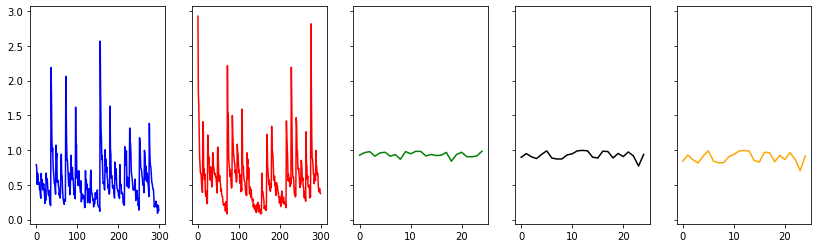

In [41]:
_,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,sharey=True,figsize=(14,4))
ax1.plot(lossL1,color='blue') # - train on 25 tasks
ax2.plot(lossL4,color='red')  # - train on new 25 tasks
ax3.plot(accsA1,color='green') # - accuraciess on training data of first 25 tasks
ax4.plot(accsA4,color='black') # - accuracies new tasks 25 tasks
ax5.plot(accsTe4,color='orange') # - test accuracies on new 25 tasks

# HW4: 
(i) Experiment with network and context sizes (ii) Try with standard MLP of similar architecture (number of neurons) and compare forgetting and forward transfer, backward negative transfer etc.